**Student Name**: Puneet

**Student Roll No**: 21f3002005

#1 Hierarchical Reinforcement Learning

For this assignment, we will be referring to Sutton, Precup and Singh’s 1999 paper, ‘Between MDPs and semi-MDPs : A Framework for Temporal Abstraction in Reinforcement Learning’. Please read the paper upto and including Section 3, it is self explanatory and a
good reference leading up to the understanding and implementation of SMDP Q-learning. Section 3 of the paper talks about SMDP planning and is necessary to build intuition to solve this assignment. We will be working with a simple taxi domain environment (explained
in the next section). Your tasks are to implement 1-step SMDP Q-Learning and intra-option Q-Learning on this environment.

#2 Environment Description
The environment for this task is the taxi domain, illustrated in Fig. 1. It is a 5x5 matrix, where each cell is a position your taxi can stay at. There is a single passenger who can be either picked up or dropped off, or is being transported. There are four designated
locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger’s location, picks up the passenger, drives to the
passenger’s destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.


There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode. Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination. This gives a total of 404 reachable discrete states.


Passenger locations: 0: R(ed); 1: G(reen); 2: Y(ellow); 3: B(lue); 4: in taxi Destinations: 0: R(ed); 1: G(reen); 2: Y(ellow); 3: B(lue)
Rewards:
 - -1 per step unless other reward is triggered.
 -  +20 delivering passenger.
 - -10 executing ”pickup” and ”drop-off” actions illegally.
The discount factor is taken to be γ = 0.9.

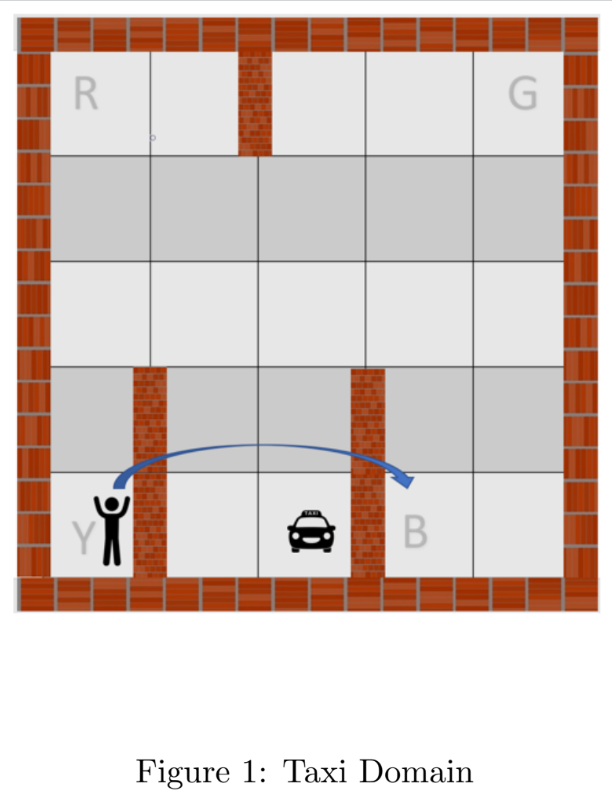

#3 Actions and Options
**Actions:** There are 6 discrete deterministic actions: 0: move south; 1: move north; 2: move east; 3: move west; 4: pick passenger up; and 5: drop passenger off.


**Options:** Options to move the taxi to each of the four designated locations, executable when the taxi is not already there.


You will be experimenting with OpenAI Gym’s Taxi-v3 environment.

# 4 Tasks
First, implement the single step **SMDP Q-learning** for solving the taxi problem. A rough sketch of the algorithm is as follows: Given the set of options,

- Execute the current selected option to termination (e.g. use epsilon greedy $Q(s, o))$.
- Computer $r(s, o)$.
- Update $Q(st, o)$.

Second, implement **intra-option Q-Learning** on the same environment.


For each algorithm, do the following (only for the configuration with the best hyperparameters):

1. Plot reward curves and visualize the learned Q-values.
2. Provide a written description of the policies learnt and your reasoning behind why
the respective algorithm learns the policy.

3. Is there an alternate set of options that you can use to solve this problem, such that this set and the given options to move the taxi are mutually exclusive? If so, run both algorithms with this alternate set of options and compare performance with the algorithms run on the options to move the taxi.


Finally, provide a comparison between the SMDP Q-Learning and intra-option Q-Learning algorithms. Do you observe any improvement with intra-option Q-Learning? If so, describe why this happens as well. Please make sure that all descriptions are brief and to the point.

In [1]:
!pip install numpy==1.23.5

# 1. Implementation of Single step SMDP Q-learning.

In [2]:
!pip install gym

In [3]:
import numpy as np
import gym
import random
from collections import defaultdict
import matplotlib.pyplot  as plt

In [4]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

In [5]:
# Create Taxi environment
env = gym.make('Taxi-v3')
env.reset(seed=42)

# Define locations (coordinates in the grid)
LOCATIONS = {
    0: (0, 0),  # Red location
    1: (0, 4),  # Green location
    2: (4, 0),  # Yellow location
    3: (4, 3)   # Blue location
}

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
def decode_state(state):
    """Decode the state to get taxi position, passenger location, and destination."""
    return list(env.decode(state))

def get_taxi_location(state):
    """Extract the taxi's location from the state."""
    decoded = decode_state(state)
    return (decoded[0], decoded[1])

def get_option_policy(state, target_loc):
    """Return the action to take to move towards target_loc."""
    taxi_row, taxi_col = get_taxi_location(state)
    target_row, target_col = LOCATIONS[target_loc]

    # Simple heuristic: move horizontally first, then vertically
    if taxi_col < target_col:
        return 2  # move east
    elif taxi_col > target_col:
        return 3  # move west
    elif taxi_row < target_row:
        return 0  # move south
    elif taxi_row > target_row:
        return 1  # move north
    else:
        return None  # we're at the target

def option_terminates(state, target_loc):
    """Check if the option to go to target_loc terminates."""
    taxi_row, taxi_col = get_taxi_location(state)
    target_row, target_col = LOCATIONS[target_loc]
    return taxi_row == target_row and taxi_col == target_col

def can_initiate_option(state, target_loc):
    """Check if the option to go to target_loc can be initiated."""
    return not option_terminates(state, target_loc)

def execute_option(env, state, target_loc, gamma=0.9):
    """Execute the option to go to target_loc until termination."""
    current_state = state
    steps = 0
    cumulative_reward = 0
    done = False

    while not option_terminates(current_state, target_loc) and not done:
        action = get_option_policy(current_state, target_loc)
        next_state, reward, done, _ = env.step(action)
        cumulative_reward += (gamma ** steps) * reward
        steps += 1
        current_state = next_state

    return current_state, cumulative_reward, steps, done

In [7]:
def smdp_q_learning(num_episodes, alpha=0.1, gamma=0.9, epsilon=0.1):
    """SMDP Q-learning implementation."""
    # Initialize Q-table for primitive actions (0-5) and options (6-9)
    q_table = defaultdict(lambda: np.zeros(10))
    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Choose an action or option using epsilon-greedy
            if random.uniform(0, 1) < epsilon:
                # Explore: choose a random action or option
                available_choices = list(range(6))  # Primitive actions
                for option in range(4):
                    if can_initiate_option(state, option):
                        available_choices.append(option + 6)
                choice = random.choice(available_choices)
            else:
                # Exploit: choose the best action or option
                available_choices = list(range(6))  # Primitive actions
                for option in range(4):
                    if can_initiate_option(state, option):
                        available_choices.append(option + 6)
                choice = max(available_choices, key=lambda c: q_table[state][c])

            # Execute the selected action or option
            if choice < 6:  # Primitive action
                next_state, reward, done, _ = env.step(choice)
                steps = 1
                total_reward += reward
            else:  # Option
                target_loc = choice - 6
                next_state, reward, steps, done = execute_option(env, state, target_loc, gamma)
                total_reward += reward

            # Update Q-value using SMDP Q-learning update rule
            best_next_choice = np.argmax(q_table[next_state])
            td_target = reward + (gamma ** steps) * q_table[next_state][best_next_choice]
            td_error = td_target - q_table[state][choice]
            q_table[state][choice] += alpha * td_error

            state = next_state
        rewards.append(total_reward)

    return q_table,rewards

In [8]:
def intra_option_q_learning(num_episodes, alpha=0.1, gamma=0.9, epsilon=0.1):
    """Intra-option Q-learning implementation."""
    # Initialize Q-table for primitive actions (0-5) and options (6-9)
    q_table = defaultdict(lambda: np.zeros(10))
    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            # Choose a primitive action using epsilon-greedy
            if random.uniform(0, 1) < epsilon:
                action = random.randint(0, 5)
            else:
                action = np.argmax(q_table[state][:6])

            # Execute the selected action
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            # Update Q-value for the primitive action
            best_next_choice = np.argmax(q_table[next_state])
            td_target = reward + gamma * q_table[next_state][best_next_choice]
            td_error = td_target - q_table[state][action]
            q_table[state][action] += alpha * td_error

            # Update Q-values for options
            for option in range(4):
                target_loc = option
                option_idx = option + 6

                # Check if the option is available and would have selected this action
                if can_initiate_option(state, target_loc) and get_option_policy(state, target_loc) == action:
                    if option_terminates(next_state, target_loc) or done:
                        # Option terminates, use off-policy update
                        best_next_choice = np.argmax(q_table[next_state])
                        td_target = reward + gamma * q_table[next_state][best_next_choice]
                    else:
                        # Option continues, use intra-option update
                        td_target = reward + gamma * q_table[next_state][option_idx]

                    td_error = td_target - q_table[state][option_idx]
                    q_table[state][option_idx] += alpha * td_error

            state = next_state
        rewards.append(total_reward)

    return q_table,rewards


In [9]:
def evaluate_policy(q_table, num_episodes=100):
    """Evaluate a policy defined by q_table."""
    total_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            # Choose the best action or option
            available_choices = list(range(6))  # Primitive actions
            for option in range(4):
                if can_initiate_option(state, option):
                    available_choices.append(option + 6)
            choice = max(available_choices, key=lambda c: q_table[state][c])

            if choice < 6:  # Primitive action
                next_state, reward, done, _ = env.step(choice)
                episode_reward += reward
                state = next_state
            else:  # Option
                target_loc = choice - 6
                next_state, reward, _, done = execute_option(env, state, target_loc)
                episode_reward += reward
                state = next_state

        total_rewards.append(episode_reward)

    return sum(total_rewards) / num_episodes , total_rewards


In [10]:
def hyperparameter_tuning(alpha_values, gamma_values, epsilon_values, num_episodes=10000, eval_episodes=100, algorithm="smdp"):
    results = []
    best_reward = float('-inf')
    best_params = None

    total_combinations = len(alpha_values) * len(gamma_values) * len(epsilon_values)
    print(f"Starting hyperparameter tuning with {total_combinations} combinations...")

    count = 0
    for alpha in alpha_values:
        for gamma in gamma_values:
            for epsilon in epsilon_values:
                count += 1
                print(f"Testing combination {count}/{total_combinations}: alpha={alpha}, gamma={gamma}, epsilon={epsilon}")

                #Training the agent.
                if algorithm == "smdp":
                  q_table,_ = smdp_q_learning(num_episodes=num_episodes, alpha=alpha, gamma=gamma, epsilon=epsilon)
                else:
                  q_table,_= intra_option_q_learning(num_episodes=num_episodes, alpha=alpha, gamma=gamma, epsilon=epsilon)

                # Evaluating the policy
                avg_reward,_ = evaluate_policy(q_table, num_episodes=eval_episodes)
                results.append((alpha, gamma, epsilon, avg_reward))

                # Keep track of the best parameters
                if avg_reward > best_reward:
                    best_reward = avg_reward
                    best_params = (alpha, gamma, epsilon, avg_reward)
                    print(f"New best parameters found: {best_params}")

    return results, best_params

In [20]:
def plot_training_rewards(rewards, window_size=1000):
    """Plot average training rewards per episode."""
    # Calculate moving average for smoother visualization
    if len(rewards) >= window_size:
        moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        episodes = range(window_size-1, len(rewards))
        plt.plot(episodes, moving_avg, label=f"Moving Average ({window_size} episodes)")
    else:
        plt.plot(range(len(rewards)), rewards, label="Episode Rewards")

    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Training Reward Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_evaluation_rewards(evaluation_rewards):
    """Plot evaluation rewards."""

    plt.plot(range(len(evaluation_rewards)), evaluation_rewards, label="Evaluation Rewards")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Evaluation Reward Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


# Function for Q-table visualization
def visualize_q_values(q_table):
    states = list(q_table.keys())
    q_values = np.array([q_table[state] for state in states])

    # Average Q-value per action/option
    avg_q_values = np.mean(q_values, axis=0)
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(avg_q_values)), avg_q_values, color="orange")
    plt.xlabel("Action/Option Index")
    plt.ylabel("Average Q-value")
    plt.title("Average Q-value for Each Action/Option")
    plt.grid(True, axis="y")
    plt.show()


In [12]:
#hyperparameter ranges
alpha_values = [0.05, 0.1]
gamma_values = [0.9, 0.95]
epsilon_values = [0.05, 0.1]

print("Starting hyperparameter tuning for SMDP Q-Learning...")
results, best_params = hyperparameter_tuning(
    alpha_values, gamma_values, epsilon_values,
    num_episodes=10000, eval_episodes=100,algorithm="smdp"
)

best_alpha, best_gamma, best_epsilon, best_reward = best_params
print(f"Best hyperparameters: alpha={best_alpha}, gamma={best_gamma}, epsilon={best_epsilon}")
print(f"Best average reward: {best_reward}")

Starting hyperparameter tuning for SMDP Q-Learning...
Starting hyperparameter tuning with 8 combinations...
Testing combination 1/8: alpha=0.05, gamma=0.9, epsilon=0.05
New best parameters found: (0.05, 0.9, 0.05, -135.40623179955782)
Testing combination 2/8: alpha=0.05, gamma=0.9, epsilon=0.1
New best parameters found: (0.05, 0.9, 0.1, -118.00613559978045)
Testing combination 3/8: alpha=0.05, gamma=0.95, epsilon=0.05
Testing combination 4/8: alpha=0.05, gamma=0.95, epsilon=0.1
New best parameters found: (0.05, 0.95, 0.1, -58.926765199999956)
Testing combination 5/8: alpha=0.1, gamma=0.9, epsilon=0.05
Testing combination 6/8: alpha=0.1, gamma=0.9, epsilon=0.1
Testing combination 7/8: alpha=0.1, gamma=0.95, epsilon=0.05
Testing combination 8/8: alpha=0.1, gamma=0.95, epsilon=0.1
Best hyperparameters: alpha=0.05, gamma=0.95, epsilon=0.1
Best average reward: -58.926765199999956


In [13]:
# Train and evaluate SMDP Q-learning with best hyperparams
smdp_q_table,rewards = smdp_q_learning(10000, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon)
smdp_avg_reward,eval_rewards = evaluate_policy(smdp_q_table)
print(f"SMDP Q-learning average reward: {smdp_avg_reward}")

SMDP Q-learning average reward: -65.30760539999997


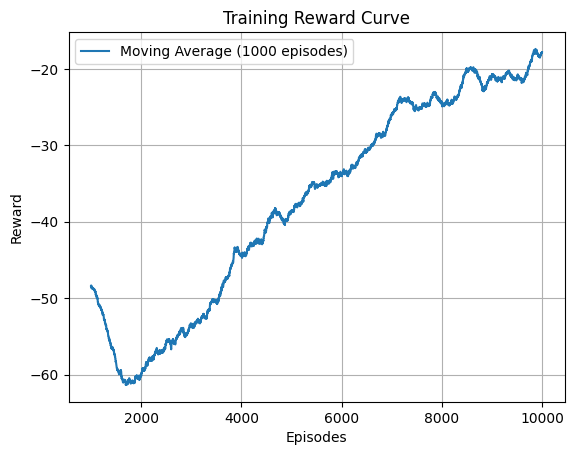

In [21]:
plot_training_rewards(rewards)

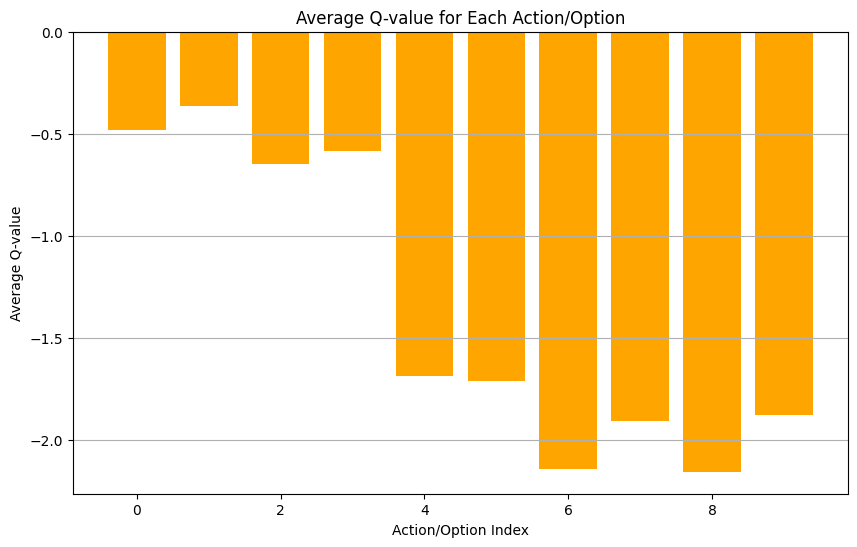

In [22]:
visualize_q_values(smdp_q_table)

In [16]:
print("Starting hyperparameter tuning for Intra-option Q-learning...")
results, best_params = hyperparameter_tuning(
    alpha_values, gamma_values, epsilon_values,
    num_episodes=10000, eval_episodes=100,algorithm="smdp"
)

best_alpha_q, best_gamma_q, best_epsilon_q, best_reward = best_params
print(f"Best hyperparameters: alpha={best_alpha}, gamma={best_gamma}, epsilon={best_epsilon}")
print(f"Best average reward: {best_reward}")

Starting hyperparameter tuning for Intra-option Q-learning...
Starting hyperparameter tuning with 8 combinations...
Testing combination 1/8: alpha=0.05, gamma=0.9, epsilon=0.05
New best parameters found: (0.05, 0.9, 0.05, -126.16428789985106)
Testing combination 2/8: alpha=0.05, gamma=0.9, epsilon=0.1
New best parameters found: (0.05, 0.9, 0.1, -117.57637849999996)
Testing combination 3/8: alpha=0.05, gamma=0.95, epsilon=0.05
New best parameters found: (0.05, 0.95, 0.05, -89.88709209999998)
Testing combination 4/8: alpha=0.05, gamma=0.95, epsilon=0.1
Testing combination 5/8: alpha=0.1, gamma=0.9, epsilon=0.05
Testing combination 6/8: alpha=0.1, gamma=0.9, epsilon=0.1
Testing combination 7/8: alpha=0.1, gamma=0.95, epsilon=0.05
Testing combination 8/8: alpha=0.1, gamma=0.95, epsilon=0.1
New best parameters found: (0.1, 0.95, 0.1, -30.083755800000002)
Best hyperparameters: alpha=0.05, gamma=0.95, epsilon=0.1
Best average reward: -30.083755800000002


In [17]:
# Train and evaluate intra-option Q-learning
intra_q_table,iq_rewards = intra_option_q_learning(10000, alpha=best_alpha_q, gamma=best_gamma_q, epsilon=best_epsilon_q)
intra_avg_reward,iq_eval_rewards = evaluate_policy(intra_q_table)
print(f"Intra-option Q-learning average reward: {intra_avg_reward}")

Intra-option Q-learning average reward: -145.04


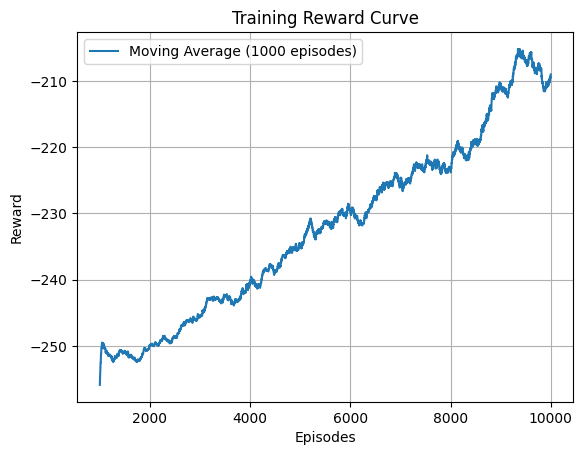

In [23]:
plot_training_rewards(iq_rewards)

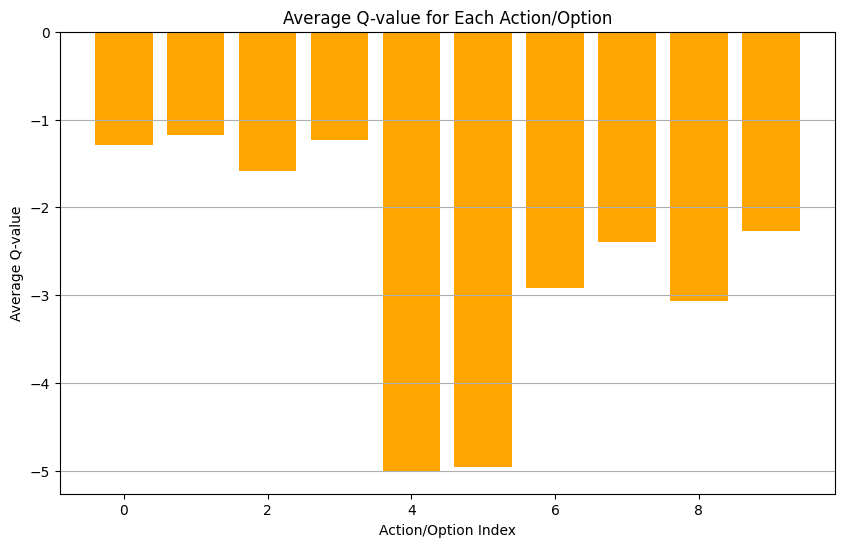

In [24]:
visualize_q_values(intra_q_table)

# 5 Submission Instructions
You are required to submit both your report and your code. Zip your code (a colab/jupyter notebook ipynb file) and report (a pdf file) together and submit.